In [2]:
source("src/plots/plot_dag.R")

# Causal Forests

Josef Nagelschmidt and Tim Mensinger

<a href="https://github.com/timmens/simulation"
   target="_parent">
    <img align="center"
         src="img/github-logo.png" width="75">
https://github.com/timmens/simulation
</a>

## Contents

0. Introduction to Causal Inference
1. Data Processes
2. Methods for Estimating Heterogeneous Treatment Effects
3. Causal Forests
4. Generalized Random Forests
5. Simulation Results
6. Live coding

## Introduction to Causal Inference

### Introductory Example

- Consider the prediction challenge
- Say the computer science department offers a weekend class on *Big data analytics* before submission are due
- Some of us go and some don't
- Prof. Freyberger grades the submissions
- First place did not attend the weekend class but the second to fifth placed all did
- We wish to ask: 
    - Did the weekend class had an effect on the quality of the submissions?
    - If so, can we estimate this effect?

### Data setting

For $i = 1,\dots, n$ (i.i.d) individuals we have

| | |
|-------|-----------------------------------------------------|
| $Y_i$ | $\mathbb{R}$-valued (observed) outcome             |
| $X_i$ | $\mathbb{R}^k$-valued (observed) feature vector     |
| $W_i$ | binary treatment indicator                          |
| $U_i, U^X_i, U^W_i$ | unobservables (here: $\mathbb{R}$-valued error term)| 

### Structural interpretation

\begin{align}
    X_i &= f(U^X_i)\\
    W_i &= h(X_i, U^W_i) =_{e.g.} 1(\tilde{h}(X_i, U^W_i) > c) \\
    Y_i &= g(X_i, W_i, U_i)
\end{align}

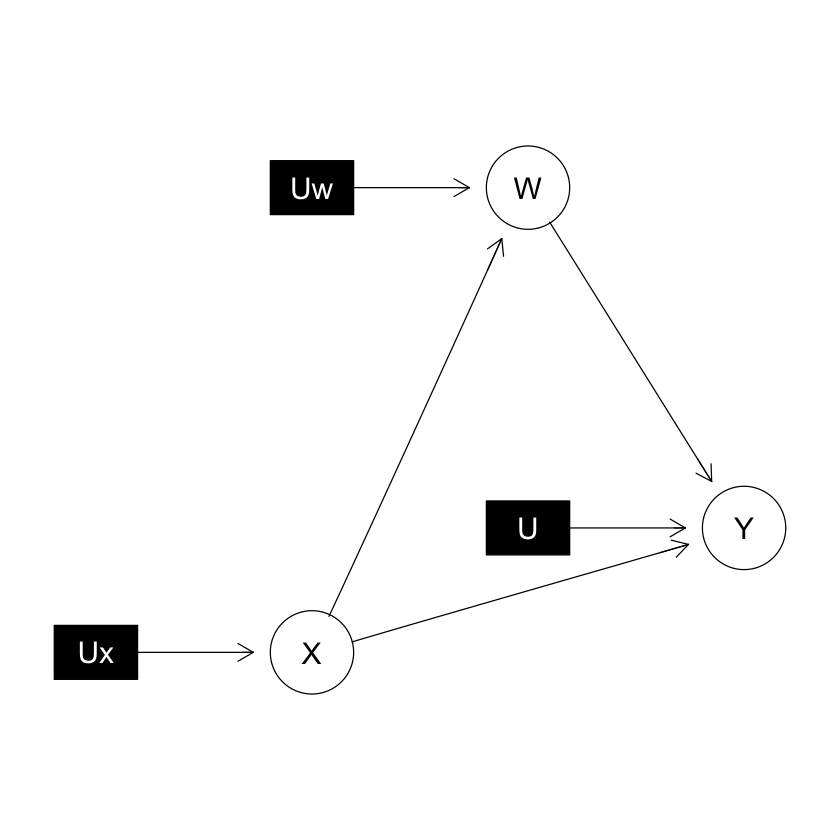

In [3]:
plot_dag()

### Causal Language and Counterfactuals

- Before estimating anything we have to formalize our notion of a *causal effect*.
- Most prominent way of thinking about this issue are so called counterfactuals.
- A counterfactual question in our example is of the form 
    - *Would the first place still be in first place had she went to the weekend class?*
    - *Would the second to fifth placed still be in the top five had they **not** went to the weekend class?*
- Mathematical formulation?

### Neyman-Rubin (Potential Outcomes) model

- Postulate existence of so called potential outcomes $Y_i(0)$ and $Y_i(1)$
- $Y_i(0) \,\,$: Outcome of $i$ given $i$ was treated
- $Y_i(1) \,\,$: Outcome of $i$ given $i$ was *not* treated

**Fundamental problem of causal inference:**

$$Y_i = W_i Y_i(1) + (1 - W_i) Y_i(0)$$

**Individual treatment effect:**

$$\tau_i := Y_i(1) - Y_i(0)$$

### Quantities of interest

| | | |
|:-------------------------------|:-----------------------------|:-----|
|Average treatment effect | $\mathbb{E}[\tau_i]$ | (ATE) |
|Average effect on the treated | $\mathbb{E}[\tau_i \mid W_i = 1]$| (ATT) |
|Conditional average treatment effect | $\mathbb{E}[\tau_i \mid X_i = x]$| (CATE) |

### Recovering the treatment effect

**Assumption 1 (Unconfoundedness):**

$$ Y_i(0), Y_i(1) \perp\hspace{-3.5pt}\perp W_i \mid X_i $$

*That is, the potential outcomes are independent of the treatment status given the (observed) features.*

**Assumption 2 (Common support):**

The propensity score function, given by $e(x) := \mathbb{P}(W_i = 1 \mid X_i = x)$ is bounded away from $0$ and $1$ for all $x \in \mathbb{R}^k$.

*That is, on all regions where $X_i$ attains values we can potentially find treated and non-treated individuals.*

### Identification of the (conditional average) treatment effect

\begin{align}
    \tau(x) &:= \mathbb{E}[\tau_i \mid X_i = x] \\
    &= \mathbb{E}[Y_i(1) - Y_i(0) \mid X_i = x] \\
    &= \mathbb{E}[Y_i(1) \mid X_i = x] - \mathbb{E}[Y_i(0) \mid X_i = x]\\
                      &= \mathbb{E}[Y_i(1) \mid W_i = 1, X_i = x] - \mathbb{E}[Y_i(0) \mid W_i = 0, X_i = x] & \text{(by A1)}\\
                      &= \mathbb{E}[Y_i \mid W_i = 1, X_i = x] - \mathbb{E}[Y_i \mid W_i = 0, X_i = x] & \text{(by def. of $Y_i$)}\\
                      &=: \mu_1(x) - \mu_0(x)
\end{align}

which is defined for all $x$ by A2.

### Estimation of the (average) treatment effect

For the sake of illustration assume $\mathbb{P}(W_i = 1 \mid X_i = x) =: e = const.$, then

\begin{align}
    \text{ATE} &= \mathbb{E}[\tau_i]\\
               &= \mathbb{E}\left[\mathbb{E}[\tau_i \mid X_i = x]\right]\\
               &= \mathbb{E}[Y_i \mid W_i = 1] - \mathbb{E}[Y_i \mid W_i = 0]\\
               &= \frac{1}{e} \mathbb{E}[Y_i \mathbb{1}(W_i=1)] - \frac{1}{1 - e} \mathbb{E}[Y_i \mathbb{1}(W_i=0)]
\end{align}

Hence,

\begin{align}
    \hat{\tau}_{ATE} &:= \frac{1}{|\{i: W_i = 1\}|} \sum_{i: W_i = 1} Y_i - \frac{1}{|\{i: W_i = 0\}|} \sum_{i: W_i = 0} Y_i\\
    &\longrightarrow_p \text{ATE}
\end{align}

## Estimation of Heterogeneous Treatment Effects

- We have a consistent estimator for the ATE
- If the treatment effect is (more or less) constant ATE $\approx$ CATE
- How do we estimate CATE in a heterogeneous case?

Next we consider: 
- various methods to estimate the (heterogeneous) treatment effect
- different versions of data processes

### Resources

- [Causal inference in Statistics](http://bayes.cs.ucla.edu/PRIMER/) -Judea Pearl, 2016
- [Mostly harmless econometrics](https://www.mostlyharmlesseconometrics.com/) -Angrist & Pischke, 2008